# House Prices Prediction

In [ ]:
!pip install category-encoders

In [2]:
 !pip install -q kaggle

# Copy Kaggle.json to Colab "/content" directory and run Cells

In [3]:
!mkdir /root/.kaggle

In [4]:
!cp /content/kaggle.json /root/.kaggle

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

# Imports and Consts

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import os

from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, learning_curve
from sklearn import pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from category_encoders import CatBoostEncoder, OrdinalEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import learning_curve
from scipy.stats import norm
from sklearn.metrics import mean_squared_log_error

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

NUM_FEATURES = 79

# Data exploration
Loading the Data from the test and train csv's

In [27]:
# Load train test dataframes
train = pd.read_csv('./train.csv')
train_size = int(len(train)*0.8)

# Sort by time and drop target and id columns
train_val = train.sort_values(['YrSold', 'MoSold'], axis=0).reset_index(drop=True)
train_val = train_val.drop(['Id'], axis=1)
train_X = train_val.drop(['SalePrice'], axis=1).loc[:train_size-1, :]
valid_X = train_val.drop(['SalePrice'], axis=1).loc[train_size:, :]
train_y = train_val['SalePrice'][:train_size]
valid_y = train_val['SalePrice'][train_size:]
test_X = pd.read_csv('./test.csv', index_col='Id')
test_X = test_X.sort_values(['YrSold', 'MoSold'], axis=0)

In [28]:
train_X.head()

MSSubClass MSZoning  LotFrontage  ...  YrSold SaleType SaleCondition
0          20       RL         78.0  ...    2006       WD        Normal
1          20       RL          NaN  ...    2006       WD        Normal
2          20       RL        118.0  ...    2006       WD        Normal
3          60       RL          NaN  ...    2006       WD        Normal
4         190       RL        100.0  ...    2006       WD        Normal

[5 rows x 79 columns]

In [29]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1168 non-null   int64  
 1   MSZoning       1168 non-null   object 
 2   LotFrontage    965 non-null    float64
 3   LotArea        1168 non-null   int64  
 4   Street         1168 non-null   object 
 5   Alley          77 non-null     object 
 6   LotShape       1168 non-null   object 
 7   LandContour    1168 non-null   object 
 8   Utilities      1168 non-null   object 
 9   LotConfig      1168 non-null   object 
 10  LandSlope      1168 non-null   object 
 11  Neighborhood   1168 non-null   object 
 12  Condition1     1168 non-null   object 
 13  Condition2     1168 non-null   object 
 14  BldgType       1168 non-null   object 
 15  HouseStyle     1168 non-null   object 
 16  OverallQual    1168 non-null   int64  
 17  OverallCond    1168 non-null   int64  
 18  YearBuil

As we see many columns has Na values. We replace all NA in categorical columns with None or similar value and numerical features with 0

In [30]:
class CustomImputer:
    def __init__(self):
        pass
    
    def fit(self, data):
        cat_cols = data.columns[data.dtypes == 'object']
        self.impute_cols = cat_cols[data[cat_cols].isna().sum() > 0] 
    
    def transform(self, data):
        for column in self.impute_cols:
            if data[column].isin(['None', 'No', 'Othr']).sum() > 0:
                replace_value = data.loc[data[column].isin(['None', 'No', 'Othr']), column].unique()[0]
                data[column] = data[column].fillna(replace_value)
            else:
                data[column] = data[column].fillna('None')
        
        return data
                
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)
    
    def get_params(self):
        pass

In [31]:
na_cols = train_X.columns[(train_X.isna().sum() > 0).values]
print(f'Columns with NA: {na_cols}')

# Replace NA values in categorical features with None and similar values        
train_X.loc[:, na_cols] = CustomImputer().fit_transform(train_X.loc[:, na_cols])
test_X.loc[:, na_cols] = CustomImputer().fit_transform(test_X.loc[:, na_cols])
valid_X.loc[:, na_cols] = CustomImputer().fit_transform(valid_X.loc[:, na_cols])

# Replace NA values in continuos features with 0 value
train_X.loc[:, na_cols[train_X.loc[:, na_cols].dtypes == 'float64']] = train_X.loc[:, na_cols[train_X.loc[:, na_cols].dtypes == 'float64']].fillna(0)

Columns with NA: Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


In [32]:
train_X.columns[train_X.isna().sum() > 0]

Index([], dtype='object')

# Feature Generation

Feature engineering is a very important step to improve our model

In [33]:
def get_sold_last_mnth(df):
    """ Generates sold houses lats month feature """
    timeline = pd.to_datetime(df['YrSold'].astype('str') + '-' + df['MoSold'].astype('str'), format='%Y-%m')
    tm_ln_indexed = pd.Series(data=timeline.index ,index=timeline.values)
    tm_ln_sold_last_mnth = tm_ln_indexed.rolling('62d').count() - tm_ln_indexed.rolling('31d').count()
    sold_lst_mnth = pd.Series(data=tm_ln_sold_last_mnth.values, index=tm_ln_indexed.values).reindex(df.index)
    return sold_lst_mnth

def get_fireplaces_per_room(df):
    """ Generates number of fireplaces per room feature """
    fp_per_house = df['Fireplaces'] / df['TotRmsAbvGrd']
    return fp_per_house

def get_quality_per_room(df):
    """ Generates quality per room feature """
    qual_per_room = df['OverallQual'] / df['TotRmsAbvGrd']
    return qual_per_room

In [34]:
# Add sold houses last month feature
train_X = train_X.assign(Sold_Lst_Mnth=lambda df: get_sold_last_mnth(df))
valid_X = valid_X.assign(Sold_Lst_Mnth=lambda df: get_sold_last_mnth(df))
test_X = test_X.assign(Sold_Lst_Mnth=lambda df: get_sold_last_mnth(df))

# Add number of fireplaces per room feature
train_X = train_X.assign(FireplacesPerRm=lambda df: get_fireplaces_per_room(df))
valid_X = valid_X.assign(FireplacesPerRm=lambda df: get_fireplaces_per_room(df))
test_X = test_X.assign(FireplacesPerRm=lambda df: get_fireplaces_per_room(df))

# Add quality per room feature
train_X = train_X.assign(QualPerRm=lambda df: get_quality_per_room(df))
valid_X = valid_X.assign(QualPerRm=lambda df: get_quality_per_room(df))
test_X = test_X.assign(QualPerRm=lambda df: get_quality_per_room(df))

# Target leakage

As we look at the data and check whether is there target leakage, It seems that **YrSold(Year when house is sold)** and **MoSold(Month when house is sold)** will cause target leakage, as we will not have such values when predicting real world house prices.

In [35]:
ta_leakage_cols = ['YrSold', 'MoSold']
train_X = train_X.drop(ta_leakage_cols, axis=1)
valid_X = valid_X.drop(ta_leakage_cols, axis=1)
test_X =test_X.drop(ta_leakage_cols, axis=1)

In [36]:
# Define catgerical and numerical features
cat_features = train_X.columns[train_X.dtypes == 'object']
num_features = train_X.columns[(train_X.dtypes == 'int64') | (train_X.dtypes == 'float64')]

# Data Visualization

Plotting wrapper class for statistics and visualization

In [37]:
class Plot(object):
    def __init__(self, nrows=20, ncols=4, figsize=(35,200), fontsize=30):
        self.nrows = nrows
        self.ncols = ncols
        self.figsize = figsize
        self.fontsize=fontsize


    def plot_grid(self, data, target_key, from_key, to_key):
        """
        Given a dataset, plots data feature distributions, corresponding to the 
        target starting from the specified key to the deserved one
        """
        
        assert to_key > from_key and to_key <= len(data.keys()), 'Invalid arguments!'

        plt.figure()
        fig, axes = plt.subplots(nrows=self.nrows, ncols=self.ncols, figsize=self.figsize)
        keys = data.keys()[from_key:to_key+1]

        for x in range(axes.shape[0]):
            for y in range(axes.shape[1]):
                if x*self.ncols+y < len(keys) and x*self.ncols+y <= to_key:
                    axes[x][y].set_ylabel(target_key, fontsize=self.fontsize)
                    axes[x][y].set_xlabel(keys[x*self.ncols+y], fontsize=self.fontsize)
                    notnan_filter = data[keys[x*self.ncols+y]].notna()

                    if not isinstance(data[keys[x*self.ncols+y]][0], str): # Numerical feature
                        axes[x][y].scatter(x=data.loc[notnan_filter, keys[x*self.ncols+y]], y=data.loc[notnan_filter, target_key])
                    else: # Categorical feature --> numerical conversion for plotting purposes
                        axes[x][y].scatter(x=data.loc[notnan_filter, keys[x*self.ncols+y]].astype('category').cat.codes, y=data.loc[notnan_filter, target_key])
                    plt.grid(True)

        plt.show()


    def plot_norm_dists(self, data, from_key, to_key):
        """
        Given a dataset, plots the data feature normal distributions
        """

        assert to_key > from_key and to_key <= len(data.keys()), 'Invalid arguments!'

        plt.figure()
        fig, axes = plt.subplots(nrows=self.nrows, ncols=self.ncols, figsize=self.figsize)
        keys = data.keys()[from_key:to_key+1]

        for x in range(axes.shape[0]):
            for y in range(axes.shape[1]):
                if x*self.ncols+y < len(keys) and x*self.ncols+y <= to_key:
                    current = data[keys[x*self.ncols+y]]
                    notnan_filter = current.notna()
                    notnan = data.loc[notnan_filter, keys[x*self.ncols+y]]

                    notnanzero = None
                    if not isinstance(notnan.tolist()[0], str): # Numerical feature
                        notnanzero_filter = current.where(current > 0).notna()
                        notnanzero = data.loc[notnanzero_filter, keys[x*self.ncols+y]]
                    else: # Categorical feature --> numerical conversion for plotting purposes
                        notnanzero = notnan.astype('category').cat.codes + 1 # Starting from class no' 1

                    # Plot the distribution
                    sns.distplot(notnanzero, fit=norm, ax=axes[x][y])

                    # Get the fitted parameters used by the function
                    (mu, sigma) = norm.fit(notnanzero)

                    # Some plot features
                    axes[x][y].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                                loc='best')
                    axes[x][y].set_ylabel('Frequency', fontsize=self.fontsize)
                    axes[x][y].set_xlabel(f'{keys[x*self.ncols+y]} distribution', fontsize=self.fontsize)
                    plt.grid(True)
                    
        plt.show()


    def plot_qq(self, data, from_key, to_key):
        """
        Given a dataset, plots the data feature QQ graphs
        """

        assert to_key > from_key and to_key <= len(data.keys()), 'Invalid arguments!'

        plt.figure()
        fig, axes = plt.subplots(nrows=self.nrows, ncols=self.ncols, figsize=self.figsize)
        keys = data.keys()[from_key:to_key+1]

        for x in range(axes.shape[0]):
            for y in range(axes.shape[1]):
                if x*self.ncols+y < len(keys) and x*self.ncols+y <= to_key:
                    current = data[keys[x*self.ncols+y]]
                    notnan_filter = current.notna()
                    notnan = data.loc[notnan_filter, keys[x*self.ncols+y]]

                    notnanzero = None
                    if not isinstance(notnan.tolist()[0], str): # Numerical feature
                        notnanzero_filter = current.where(current > 0).notna()
                        notnanzero = data.loc[notnanzero_filter, keys[x*self.ncols+y]]
                    else: # Categorical feature --> numerical conversion for plotting purposes
                        notnanzero = notnan.astype('category').cat.codes + 1 # Starting from class no' 1
 
                    # Plot the QQ graph
                    # plt.rcParams['axes.titlesize'] = self.fontsize
                    stats.probplot(notnanzero, plot=axes[x][y])
                    axes[x][y].xaxis.get_label().set_fontsize(self.fontsize)
                    axes[x][y].yaxis.get_label().set_fontsize(self.fontsize)
                    # axes[x][y].set_title(keys[x*self.ncols+y])
                    plt.grid(True)
        
        plt.show()

In [38]:
plot_wrapper = Plot()

Graphs Showing how the Sales Price is distributed by the given features

<Figure size 432x288 with 0 Axes>

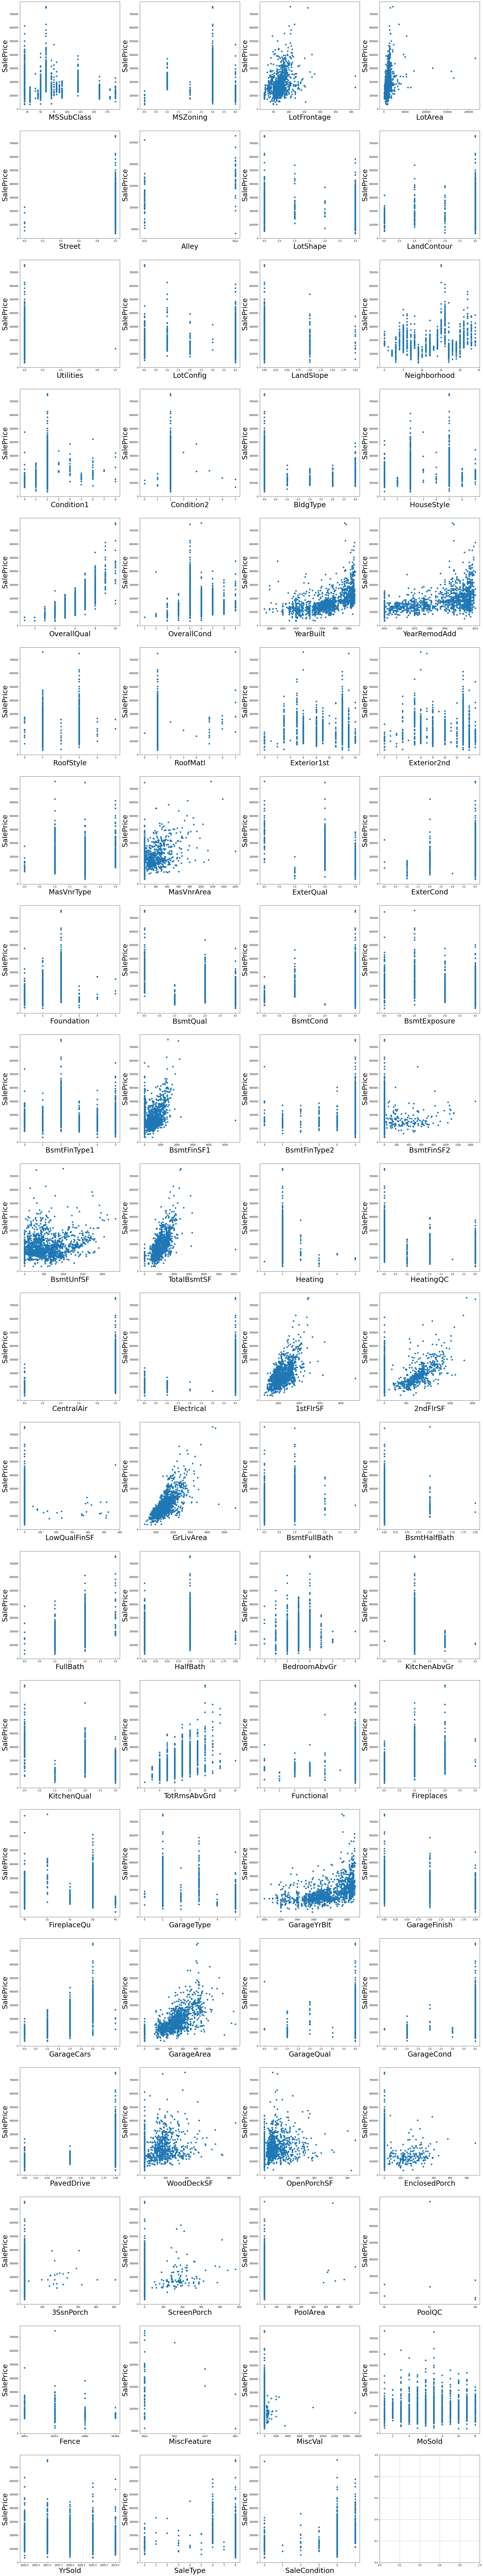

In [40]:
plot_wrapper.plot_grid(train_val, 'SalePrice', 0, NUM_FEATURES-1)

Plot the feature and the target distributions

<Figure size 432x288 with 0 Axes>

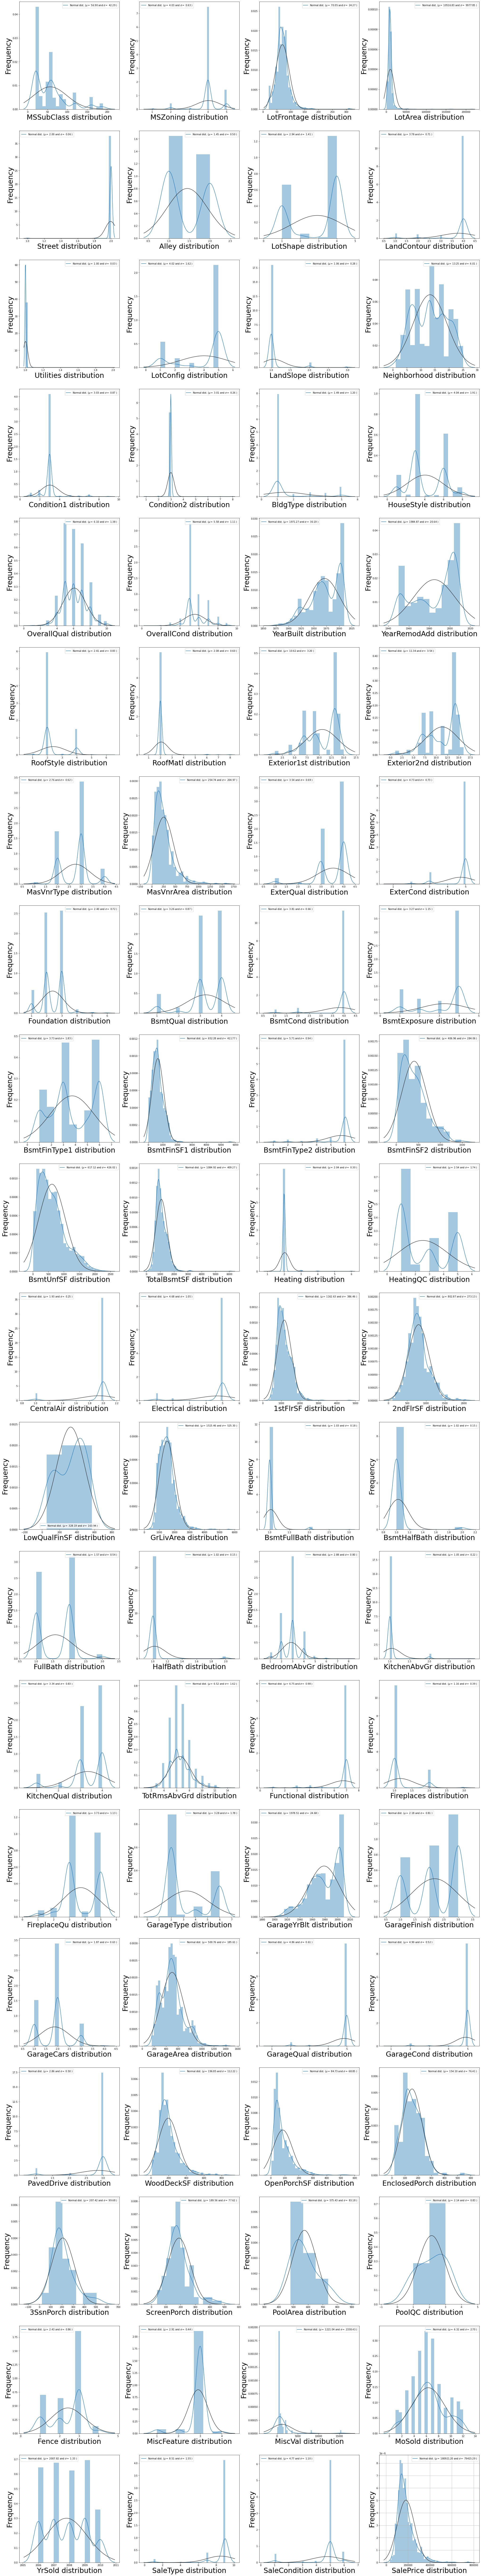

In [43]:
plot_wrapper.plot_norm_dists(train_val, 0, NUM_FEATURES+1) # +1 --> including the target SalePrice

# Correlation Map for the target Value: SalePrice
As we can see, there are a number of features that correlate directly to the sales price such as over all quality, GrLivArea, GarageCars and more.
We can notice that other features correlate together, such as GarageYrBuilt, GarageArea, GarageCars.
Note: notice how every feature correlates 1 with itself..

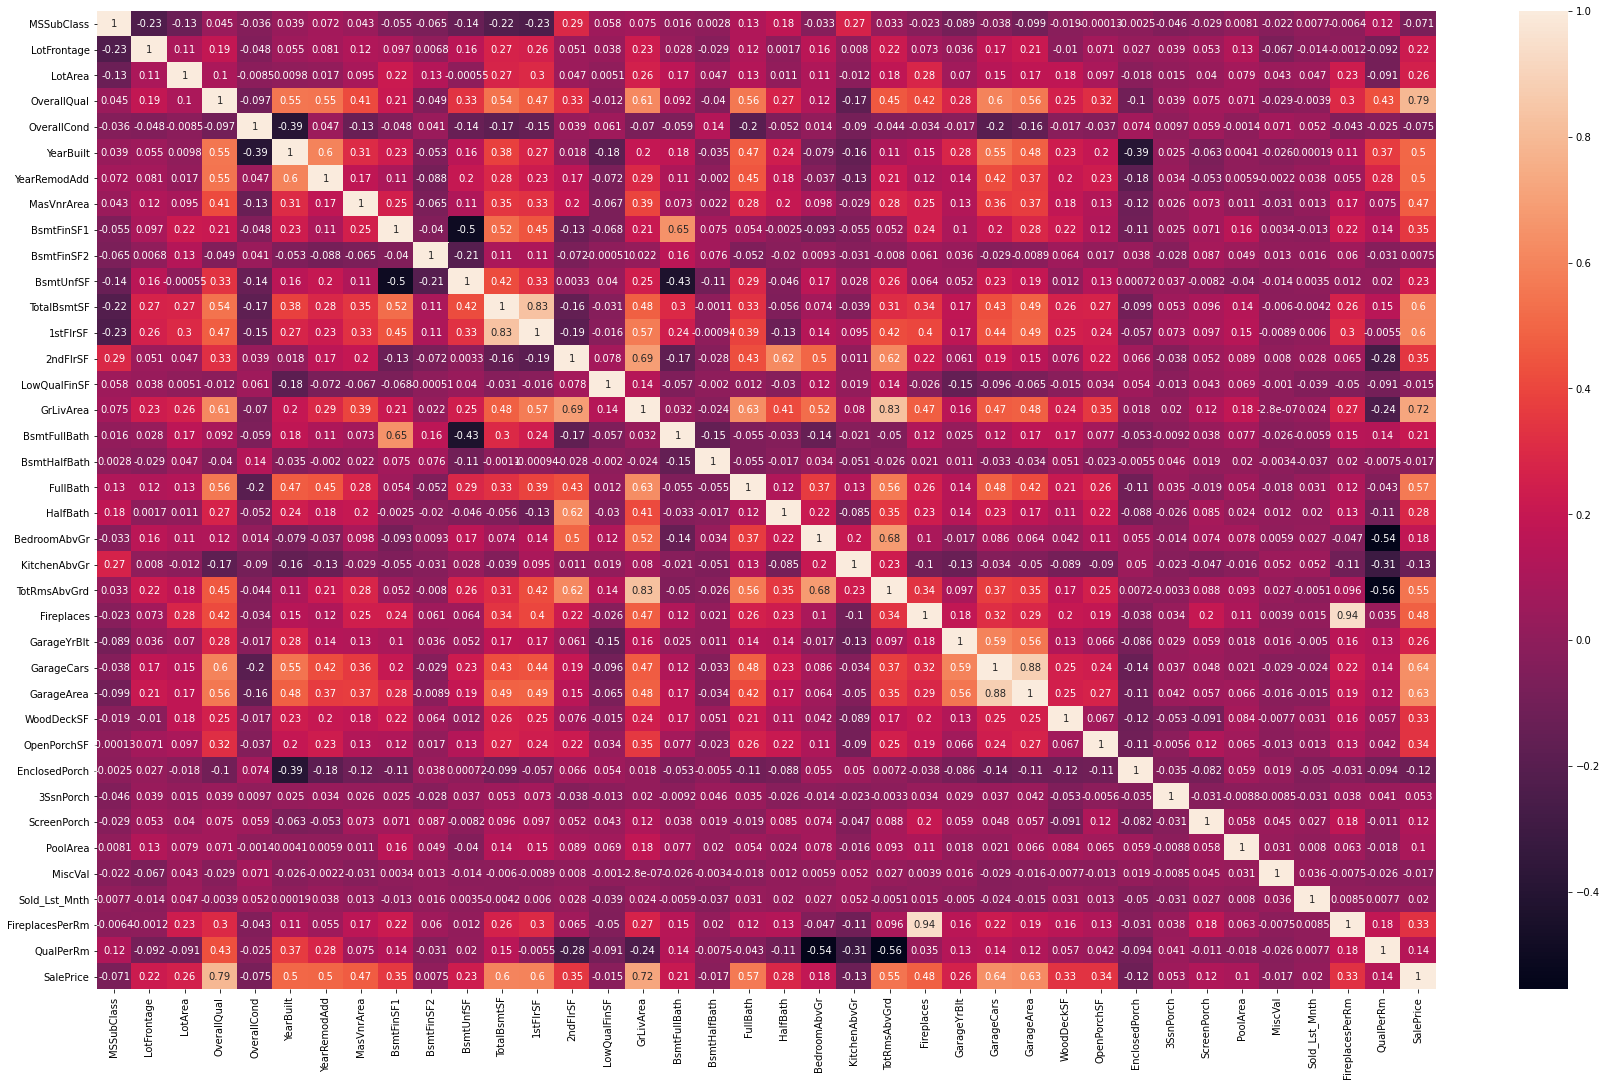

In [44]:
plt.figure(figsize=(30, 18))
sns.heatmap(pd.concat([train_X[num_features], train_y], axis=1).corr(), annot=True)

# Data Transformation

For ordinal data we will use OrdinalEncoder(as it much more apropriated for Tree-Based models) and CatBoostEncoder for nominal, and for numerical Standard Scaler

In [45]:
# Lets divide or categorical features on ordinal and nominal
ordinal_features = [
    'LandSlope',
    'Condition1',
    'Condition2',
    'ExterQual',
    'ExterCond',
    'BsmtQual',
    'BsmtCond',
    'BsmtFinType1',
    'BsmtFinType2',
    'HeatingQC',
    'KitchenQual',
    'FireplaceQu',
    'GarageQual',
    'GarageCond',
    'PoolQC'
]

nominal_features = cat_features.drop(ordinal_features)
# Next define transformer of nominal features
nominal_transformer = pipeline.Pipeline(steps=[
    ('cat_boost', CatBoostEncoder()),
    ('scaler', StandardScaler())
])

# Nest feature transformations of numerical ans ordinal cols
num_transformer = pipeline.Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, missing_values=np.nan)),
    ('scaler', StandardScaler())
])

num_ord_transformer = ColumnTransformer(transformers=[
    ('ordinal_transformer', OrdinalEncoder(), ordinal_features),
    ('num_transformer', num_transformer, num_features)
])

# First transform our nominal features
train_X_nominal = nominal_transformer.fit_transform(train_X[nominal_features], train_y)
valid_X_nominal = nominal_transformer.transform(valid_X[nominal_features])
test_X_nominal = nominal_transformer.transform(test_X[nominal_features])

# Next transform ordinal and numerical features
train_X_num_ord = num_ord_transformer.fit_transform(train_X)
valid_X_num_ord = num_ord_transformer.transform(valid_X)
test_X_num_ord = num_ord_transformer.transform(test_X)

# Finally we concatenate such arrays
train_X_transformed = np.concatenate((train_X_nominal, train_X_num_ord), axis=1)
valid_X_transformed = np.concatenate((valid_X_nominal, valid_X_num_ord), axis=1)
test_X_transformed = np.concatenate((test_X_nominal, test_X_num_ord), axis=1)

# Hyper Parameter Tuning
we want to find the best learning rate for the XGB regresson model

In [ ]:
params = {
    'learning_rate': np.arange(0.01, 0.11, 0.01)
}

optimizer = GridSearchCV(XGBRegressor(n_estimators=500, tree_method='gpu_hist', max_depth=4, min_child_weight=3, gamma=0, colsample_bytree=0.4, subsample=0.7, learning_rate=0.05), params, cv=TimeSeriesSplit(n_splits=3), n_jobs=-1)
optimizer.fit(train_X_transformed, train_y)

In [53]:
valid_score = np.sqrt(mean_squared_log_error(valid_y, optimizer.predict(valid_X_transformed)))
print(valid_score)

0.1385238745071411


In [54]:
optimizer.best_params_

{'learning_rate': 0.01}

In [55]:
pd.DataFrame(optimizer.cv_results_)

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0       4.953349      0.117700  ...        0.093808                1
1       4.903413      0.173011  ...        0.116220                2
2       4.895389      0.156558  ...        0.116676                3
3       4.971458      0.120186  ...        0.120649                4
4       4.977706      0.130466  ...        0.122539                5
5       4.992151      0.135550  ...        0.135689                6
6       4.978083      0.112211  ...        0.135464                8
7       5.018793      0.112420  ...        0.125803                9
8       5.007240      0.081971  ...        0.128475               10
9       4.890095      0.159053  ...        0.125857                7

[10 rows x 12 columns]

# Training Model

In [56]:
xgb_params = {
    'colsample_bytree': 0.4,
    'n_estimators': 1000,
    'min_child_weight': 3,
    'max_depth': 6,
    'subsample': 0.4,
    'learning_rate': optimizer.best_params_['learning_rate'],
    'gamma': 0,
    'reg_lambda': 0.02
}

model = XGBRegressor(tree_method='gpu_hist', **xgb_params).fit(train_X_transformed, train_y)

[19:57:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# Model evaluation

First we calculate RMSLE on train and validation datasets, next we'll plot learning curves

In [57]:
train_score = np.sqrt(mean_squared_log_error(train_y, model.predict(train_X_transformed)))
print(f'Root Mean Squared Log train score is {train_score}')

Root Mean Squared Log train score is 0.051791135093130374


In [58]:
valid_score = np.sqrt(mean_squared_log_error(valid_y, model.predict(valid_X_transformed)))
print(f'Root Mean Squared Log validation score is {valid_score}')

Root Mean Squared Log validation score is 0.12917080114176852


Lets plot learning curve to define whether we have high biase or variance(underfitting and overfitting)

In [59]:
def plot_learning_curve(estimator, X_train, y_train, cv, train_sizes=np.linspace(0.1, 1, 10)):
    plt.style.use('seaborn-darkgrid')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X_train, y_train, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_mean_scores = np.mean(train_scores, axis=1)
    test_mean_scores = np.mean(test_scores, axis=1)
    plt.title('Learning curve')
    plt.plot(train_sizes, train_mean_scores, 'y', label='Train Learning curve')
    plt.plot(train_sizes, test_mean_scores, 'b', label='Test Learning curve')
    plt.legend()

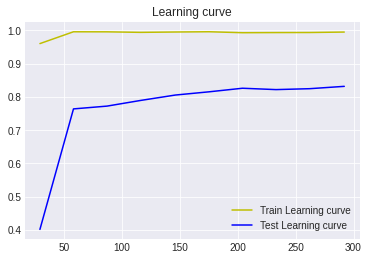

In [60]:
plot_learning_curve(model, train_X_transformed, train_y, TimeSeriesSplit(n_splits=3))

# Create Submissions




In [61]:
preds_test = model.predict(test_X_transformed)
output = pd.DataFrame({'Id': test_X.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)